### Блок практики

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from scipy.stats import skew

pd.options.display.max_columns = 500

Снова потренируемся в предсказании цен на недвижимость из [очередного датасета с каггла](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/)! В качестве основной метрики для валидации моделей будем использовать, как и ранее, `MSLE`.

P.S. в данной домашней работе при построении любых моделей, использующих недетерменированные элементы (как бутстрап), в алгоритме указывайте параметр `random_state = 1` для воспроизводимости результатов.

In [2]:
df = (
    pd.read_csv('train.csv')
    .drop('Id', axis=1)
)

df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,1,0,2,1,Gd,

In [3]:
### Разделим выборку на объекты-таргеты
X = df.drop(columns='SalePrice')
y = df['SalePrice']
# your code here

In [4]:
### Логарифмируем таргет для будущей оптимизации
### MSLE через MSE
y_log = y.apply(np.log1p)
# your code here

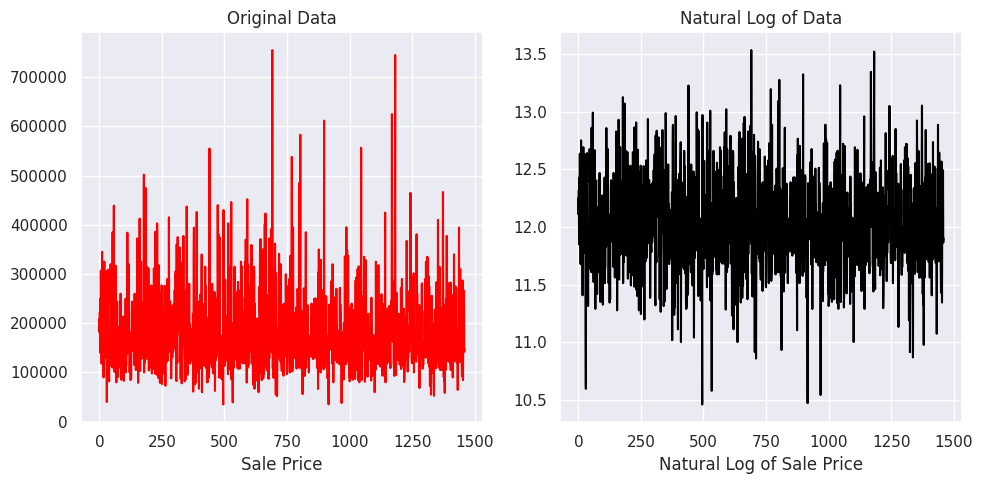

In [6]:
### Это позволяет получить нормальное распределение таргета
### Важно, например, для построения корректной
### С точки зрения статистических свойств
### Линейной модели.
### Хотя здесь мы будем строить ансамбли деревьев, 
### И это не особо интересно.

sns.set_theme(rc={'figure.figsize':(15,10)})

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(y,color = 'red')
plt.title('Original Data')
plt.xlabel('Sale Price')

plt.subplot(1,2,2)
# your code here (постройте график логарифмированного таргета)
plt.plot(y_log,color='black')
plt.title('Natural Log of Data')
plt.xlabel('Natural Log of Sale Price')
plt.tight_layout()

### В начале поработаем с пропусками!

Если в какой-либо колонке оказывается достаточно много пропусков, обычно советуют от них избавляться. Мотивировано это тем, что в таких фичах мы можем наблюдать серьезный недостаток информативности, а заполнение пропусков может лишь внести лишнего шума в данные.

Избавьтесь от всех колонок, в которых пропусков оказывается больше 15%. (1б)

In [10]:
### Можно воспользоваться такой компактной конструкцией

# your code here
print(X.columns)
X.dropna(axis=1,thresh=0.85*X.shape[0])
X.columns


Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

Вещественные колонки заполните медианным значением по фиче, а категориальные - самой популярной по колонке категорией. (2б)

Заметьте, что колонки `MoSold`, `YrSold`, `GarageYrBlt`, `YearBuilt`, `YearRemodAdd` хоть в таблице не являются типами `object`, вряд ли их справедливо использовать как вещественные. Переведите все значения внутри в строки.

In [27]:
# your code here
from collections import Counter
Counter(X.dtypes.to_list())



Counter({dtype('O'): 43, dtype('int64'): 33, dtype('float64'): 3})

In [30]:
num_cols = X.select_dtypes(include=['int64','float64']).columns
cat_cols = X.select_dtypes(include='O').columns
X[cat_cols] = df[cat_cols].astype('object')

X[num_cols] = X[num_cols].fillna(X[num_cols].median())
X[cat_cols] = X[cat_cols].fillna(X[cat_cols].mode().iloc[0])

In [31]:
### Отложенная выборка
X_train, X_test,y_train,y_test = train_test_split(X,y_log,test_size=0.25,random_state=1)
# your code here

Напишите трансформер, который будет делать следующее:

1. Масштабирование через StandardScaler для вещественных колонок
2. Кодирование через OneHotEncoder для категориальных, содержащих менее, чем 5 уникальных значений
3. Кодирование через TargetEncoder для всех остальных категориальных

Для этого советуем воспользоваться библиотекой `category_encoders` помимо `sklearn`.

А так же классом `ColumnTransformer` из `sklearn.compose`.

P.S. Напомним, что для деревьев процедура StandardScaling не обязательна (решающие деревья нечувствительны к масштабу). Тем не менее, это может сделать обучение модели менее тяжелым (хранить большие числа сложно для задач с большим количеством данных).

In [34]:
# your code here
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,TargetEncoder,StandardScaler

col_for_ohe = [x for x in cat_cols if X[x].nunique() < 5] 
col_for_mte = [x for x in cat_cols if X[x].nunique() >= 5]

col_for_ohe_idx = [list(X.columns).index(col) for col in col_for_ohe]

col_for_mte_idx = [list(X.columns).index(col) for col in col_for_mte]

num_cols_idx = [list(X.columns).index(col) for col in num_cols]

col_transformer = ColumnTransformer([('OneHotEncoder',OneHotEncoder(),col_for_ohe_idx),
                                     ('MeanTargetEncoder',TargetEncoder(),col_for_mte_idx),
                                     ('Scaler', StandardScaler(),num_cols_idx)])

Посмотрите, как на наших данных справляется одно Решающее Дерево с дефолтными гиперпараметрами. Добавьте написанный ранее трансформер в модель. (1б)

In [35]:
# your code here
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline

pipe = Pipeline(
    [
        ('Transformer',col_transformer),
        ('DTR',DecisionTreeRegressor())
    ]
)
pipe.fit(X_train,y_train)
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

In [38]:
# your code here (посчитайте ошибки на трейне и тесте)
from sklearn.metrics import mean_squared_error
print("train acc:",mean_squared_error(y_train,y_pred_train))
print("test acc:",mean_squared_error(y_test,y_pred_test))

train acc: 0.008756923260003
test acc: 0.042141744621075346


Справляется даже без контроля переобучения!

Посмотрим на перформанс Случайного Леса! Подберите параметры по отложенной выборке по данной сетке `param_grid`. Помните, что подбирать количество деревьев не супер обязательно, достаточно поставить их побольше. Что произошло с качеством модели по сравнению с одиноким деревом? (2б)

In [40]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    "RF__max_depth": [10, 15, 20],
    "RF__min_samples_split": [2, 5, 10],
    "RF__min_samples_leaf": [1, 3, 5]
}
custom_cv = [(X_train.index.to_list(), X_test.index.to_list())]
pipe_rf = Pipeline(
    [
        ("Transformer",col_transformer),
        ("RF",RandomForestRegressor())
    ]
)
grid = GridSearchCV(pipe_rf,param_grid=param_grid,cv=custom_cv,scoring='neg_mean_squared_error',verbose=10)

grid.fit(X,y_log)
print(f"Best parameter (CV score={grid.best_score_:.5f}):")
print(grid.best_params_)

Fitting 1 folds for each of 27 candidates, totalling 27 fits
[CV 1/1; 1/27] START RF__max_depth=10, RF__min_samples_leaf=1, RF__min_samples_split=2
[CV 1/1; 1/27] END RF__max_depth=10, RF__min_samples_leaf=1, RF__min_samples_split=2;, score=-0.019 total time=   1.6s
[CV 1/1; 2/27] START RF__max_depth=10, RF__min_samples_leaf=1, RF__min_samples_split=5
[CV 1/1; 2/27] END RF__max_depth=10, RF__min_samples_leaf=1, RF__min_samples_split=5;, score=-0.019 total time=   1.4s
[CV 1/1; 3/27] START RF__max_depth=10, RF__min_samples_leaf=1, RF__min_samples_split=10
[CV 1/1; 3/27] END RF__max_depth=10, RF__min_samples_leaf=1, RF__min_samples_split=10;, score=-0.019 total time=   1.3s
[CV 1/1; 4/27] START RF__max_depth=10, RF__min_samples_leaf=3, RF__min_samples_split=2
[CV 1/1; 4/27] END RF__max_depth=10, RF__min_samples_leaf=3, RF__min_samples_split=2;, score=-0.020 total time=   1.2s
[CV 1/1; 5/27] START RF__max_depth=10, RF__min_samples_leaf=3, RF__min_samples_split=5
[CV 1/1; 5/27] END RF__max

Посмотрим на лучшие параметры:

In [41]:
grid.best_params_

{'RF__max_depth': 20, 'RF__min_samples_leaf': 1, 'RF__min_samples_split': 2}

In [45]:
pipe_rf.set_params(**grid.best_params_)

Pipeline(steps=[('Transformer',
                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                  OneHotEncoder(),
                                                  [4, 5, 6, 7, 8, 10, 24, 26,
                                                   29, 30, 31, 40, 52, 59, 64,
                                                   71, 72, 73]),
                                                 ('MeanTargetEncoder',
                                                  TargetEncoder(),
                                                  [1, 9, 11, 12, 13, 14, 15, 20,
                                                   21, 22, 23, 27, 28, 32, 34,
                                                   38, 39, 41, 54, 56, 57, 62,
                                                   63, 77, 78]),
                                                 ('Scaler', StandardScaler(),
                                                  [0, 2, 3, 16, 17, 18, 19, 25,
                                                   33, 35, 36, 37, 42, 43, 44,
                                                   45, 46, 47, 48, 49, 50, 51,
                                                   53, 55, 58, 60, 61, 65, 66,
                                                   67, ...])])),
                ('RF', RandomForestRegressor(max_depth=20))])

In [46]:
pipe_rf.fit(X_train,y_train)
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)
print("train acc:",mean_squared_error(y_train,y_pred_train))
print("test acc:",mean_squared_error(y_test,y_pred_test))

train acc: 0.008756923260003
test acc: 0.042141744621075346


Попробуем теперь поэкспериментировать с бэггингами. 

Постройте бэггинги с 100 базовыми моделями (и остальными стандартными параметрами) над линейной регрессией, деревом и случайным лесом (бэггинг над бэггингом!). 

Какое качество у каждой модели на тесте?

Какой алгоритм получился лучше с точки зрения качества на тесте? (2б)

In [59]:
# your code here
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import Lasso
BR_DT = BaggingRegressor(DecisionTreeRegressor(max_depth=20,min_samples_leaf=1),100,random_state=1,n_jobs=-1)


BR_LR = BaggingRegressor(Lasso(),100,random_state=1,n_jobs=-1)
    
BR_RF = BaggingRegressor(RandomForestRegressor(),100,random_state=1,n_jobs=-1)

error_list = {}
models = [BR_DT,BR_LR,BR_RF]
for i in models:
    pipe = Pipeline([
        ("transformer",col_transformer),
        ('bagger',i)
    ])
    pipe.fit(X_train,y_train)
    y_pred_train = pipe.predict(X_train)
    y_pred_test = pipe.predict(X_test)
    error_list[f'{i} train error'] = mean_squared_error(y_train,y_pred_train)
    error_list[f'{i} test error'] = mean_squared_error(y_test,y_pred_test)


ValueError: too many values to unpack (expected 2)

In [61]:
# your code here (соберите результаты)
for key in error_list.keys():
    print(f'{key}:{error_list[key]}\n')


BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=20),
                 n_estimators=100, n_jobs=-1, random_state=1) train error:0.004544816370548565

BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=20),
                 n_estimators=100, n_jobs=-1, random_state=1) test error:0.018018873434072664

BaggingRegressor(estimator=Lasso(), n_estimators=100, n_jobs=-1, random_state=1) train error:0.15635992914935792

BaggingRegressor(estimator=Lasso(), n_estimators=100, n_jobs=-1, random_state=1) test error:0.16910389569692108

BaggingRegressor(estimator=RandomForestRegressor(), n_estimators=100, n_jobs=-1,
                 random_state=1) train error:0.009147341052565924

BaggingRegressor(estimator=RandomForestRegressor(), n_estimators=100, n_jobs=-1,
                 random_state=1) test error:0.01900059163816533



### Добавим новые фичи!

Создайте следующие четыре новые вещественные фичи:

1. Отношения площади 1 этажа к общей площади (колонки 1stFlrSF и GrLivArea, в %)
2. Отношение Площади завершенного фундамента первого типа к общей площади фундамента (колонки BsmtFinSF1 и TotalBsmtSF, в %)
3. Возраст дома (между YearBuilt и YrSold)
4. Общая площадь самого дома и фундамента/цоколя (1stFlrSF + 2ndFlrSF + TotalBsmtSF)

Обучите заново Случайный лес и найдите лучшие гиперпараметры на старой сетке.

Улучшили ли качество модели новые фичи? (4б)

In [70]:
df.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,69.863699,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.117123,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.589041,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,22.027677,9981.264932,1.382997,1.112799,30.202904,20.645407,180.731373,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,23.997022,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,60.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1962.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,79.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2001.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [71]:
# your code here (создайте новые фичи)
def FirstFlr_to_LivArea(x):
    if x['GrLivArea'] == 0:
        return 0
    else:
        return x['1stFlrSF'] * 100 / x['GrLivArea']
def BsmtFin_to_TotalBsmt(x):
    if x['TotalBsmtSF'] == 0:
        return 0
    else:
        return x['BsmtFinSF1'] * 100 / x['TotalBsmtSF']
    
def House_Age(x):
    return x['YrSold'] - x['YearBuilt']
def TotalArea(x):
        return x['1stFlrSF'] + x['2ndFlrSF'] + x['TotalBsmtSF']

In [72]:
X['First_to_LivArea'] = X.apply(lambda x:FirstFlr_to_LivArea(x),axis=1)
X['BsmtFin_to_TotalBsmt'] = X.apply(lambda x: BsmtFin_to_TotalBsmt(x), axis=1)
X['House_Age'] = X.apply(lambda x: House_Age(x),axis=1)
X['TotalArea'] = X.apply(lambda x: TotalArea(x),axis=1)
X_train,X_test,y_train,y_test = train_test_split(X,y_log,test_size=0.25)

In [73]:
# your code here (обновите трансформер и повторите обучение случайного леса)
numeric_cols_idx = num_cols_idx + [X_test.shape[1]-i for i in range(1, 5)]

t = [('OneHotEncoder', OneHotEncoder(), col_for_ohe_idx),
     ('MeanTargetEncoder', TargetEncoder(), col_for_mte_idx),
     ('StandardScaler', StandardScaler(), numeric_cols_idx)]

col_transformer = ColumnTransformer(transformers=t)


In [74]:
param_grid = {
    "random_forest__max_depth": [10, 15, 20],
    "random_forest__min_samples_split": [2, 5, 10],
    "random_forest__min_samples_leaf": [1, 3, 5]
}

pipe_rf = Pipeline([("column_transformer",
                     col_transformer),
                     
                    ("random_forest", 
                     RandomForestRegressor(random_state=1))])

search = GridSearchCV(pipe_rf, 
                      param_grid, 
                      cv=custom_cv,
                      scoring='neg_mean_squared_error',
                      verbose=10)

search.fit(X, y)

print(search.best_params_)
pipe_rf.set_params(**search.best_params_)
pipe_rf.fit(X_train, y_train)
train_preds = pipe_rf.predict(X_train)
test_preds = pipe_rf.predict(X_test)

train_error = mean_squared_error(y_train,train_preds)
test_error = mean_squared_error(y_test,test_preds)


print(f"Качество на трейне: {train_error}")
print(f"Качество на тесте: {test_error}")

Fitting 1 folds for each of 27 candidates, totalling 27 fits
[CV 1/1; 1/27] START random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=2
[CV 1/1; 1/27] END random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=2;, score=-832670483.189 total time= 2.9min
[CV 1/1; 2/27] START random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=5
[CV 1/1; 2/27] END random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=5;, score=-830476110.148 total time= 2.6min
[CV 1/1; 3/27] START random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=10
[CV 1/1; 3/27] END random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=10;, score=-853590453.941 total time= 2.3min
[CV 1/1; 4/27] START random_forest__max_depth=10, random_forest__min_samples_leaf=3, random_fores

In [75]:
train_error = np.mean((train_preds - y_train)**2)
test_error = np.mean((test_preds - y_test)**2)


print(f"Качество на трейне: {train_error}")
print(f"Качество на тесте: {test_error}")

Качество на трейне: 0.003948174275625829
Качество на тесте: 0.02456929170532616
